# Malaria classification

This implementation would be covering a binary classifcation problem using image data

## Libraries used for the project

In [2]:
import os

# Image libraries:
from skimage.io import imread,imsave,imshow
from skimage.filters import sobel,thresholding
from skimage.exposure import histogram
from skimage.morphology import watershed
from skimage.color import label2rgb
# image transformations (augmentations):
from skimage.transform import resize
from keras.preprocessing.image import random_rotation,random_shear,random_shift,random_zoom
from scipy import ndimage

# visuals:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import pylab

# data structures:
import pandas as pd
import numpy as np
from collections import Counter

# Data splitting:
from sklearn.model_selection import train_test_split

# Data scaling:
from sklearn.preprocessing import RobustScaler,OneHotEncoder

# Model evaluation metrics:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,\
                            roc_auc_score,roc_curve,precision_recall_curve


# Naive Bayes model:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

# Logistic Regression model:
from sklearn.linear_model import LogisticRegression

# Keras model:
from keras.losses import binary_crossentropy
from keras.models import Sequential,load_model
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
from keras.layers import Dense,Dropout,BatchNormalization,Conv2D,MaxPooling2D,Flatten
# from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg19

import warnings
warnings.filterwarnings('ignore');

# Renaming image files and writing it to a common directory

In [7]:
root = '..\\data'
aug_root = '..\\data\\augmented'

In [3]:
counter = 0
for dir1 in os.listdir(path=root):
    if dir1 != 'augmented':
        if dir1.find('.') == -1: #not jpg files
            for dir2 in os.listdir(os.path.join(root,dir1)):
                for file in os.listdir(os.path.join(root,dir1,dir2)):
                    filepath = os.path.join(root,dir1,dir2,file)
                    filename = file
                    if filename.find('uninfected') != -1:
                        new_filename = 'uninfected'+'_'+str(counter)+'.jpg'
                    else:
                        new_filename = 'infected'+'_'+str(counter)+'.jpg'
                    counter += 1
                    if not os.path.exists(path=os.path.join(root,new_filename)):
                        imsave(fname=os.path.join(root,new_filename),arr=imread(fname=filepath))
    #                     print(new_filename)

# Collect all data into a dataframe

In [4]:
data = pd.DataFrame([(os.path.join(root,i),i,i.split('_')[0]) for i in os.listdir(path=root) if i.find('.') != -1],
                    columns=['image_location','image_name','image_label'])

# Augmentation function

This function takes as input the location of the image, the shape of the image, the pixel representation of the image and a parameter 'training' to indicate if the image should just pass through or go via a random transformation scheme. The transformation consists of rotation, shear, shift and zoom. The reason for this is to introduce more randomness in order to achieve model stability and avoid over fitting, it is also a great technique to produce more data should you be provided with an insificient amount of observations (which is typically the case).

In [5]:
def image_augmentation(img,img_shape=(100,100,3),gray_scale=False,training=True): # (100,100) for gray and (100,100,3) for color
    
    img = imread(fname=img,as_gray=gray_scale)
    img = resize(image=img,output_shape=img_shape)
    
    if training: #choose randomly to augment or not
        augment = np.random.choice(a=['yes','no'])
    else: #else don't augment
        augment = 'no'
    
    if augment == 'no':
        
        return img
    else:
        # randomly choose a transformation:
        transformation = np.random.choice(a=[1,2,3,4],size=1,replace=True)
        if transformation == 1: # perform rotation
            img = random_rotation(x=img,rg=np.random.choice(a=np.arange(start=0,stop=361,step=1)),row_axis=1,\
                                  col_axis=0,channel_axis=2)
        elif transformation == 2: # perform shear
            img = random_shear(x=img,intensity=np.random.choice(a=np.arange(start=0,stop=361,step=1)),row_axis=1,\
                               col_axis=0,channel_axis=2)
        elif transformation == 3: # perform shift
            img = random_shift(x=img,wrg=np.random.choice([0.1,0.2,0.3,0.4]),hrg=np.random.choice([0.1,0.2,0.3,0.4]),\
                               row_axis=1,col_axis=0,channel_axis=2)
        elif transformation == 4: # perform zoom
            img = random_zoom(x=img,zoom_range=(np.random.choice([0.3,0.4,0.5,1]),np.random.choice([0.3,0.4,0.5,1])),\
                              row_axis=1,col_axis=0,channel_axis=2)
        else:
            img = img

        return img

# Generate and save augmented images

This code randomly samples a 1000 images from the current available pool of observations with replacement. For each of these images 10 random transformation will be performed and the images saved to a folder. This whole process is repeated 10 times.

In [3]:
last_image_num = np.max(data['image_name'].apply(lambda x: int(x.split('_')[1].split('.')[0])).values)
new_numbering_start = last_image_num + 1
for i in range(10):
    for img in list(data['image_location'].sample(n=1000,replace=True).apply(lambda x: (x,x.split('\\')[2].split('_')[0]))):
        for aug in range(10):
            filename = img[1] + '_' + str(new_numbering_start) + '.jpg' 
            imsave(fname=os.path.join(aug_root,filename),arr=image_augmentation(img=img[0],img_shape=(100,100,3),gray_scale=False,training=True))
            new_numbering_start += 1
;           

# Combine augmented images to the given images

In [8]:
aug_data = pd.DataFrame([(os.path.join(aug_root,i),i,i.split('_')[0]) for i in os.listdir(path=aug_root) if i.find('.') != -1],
                    columns=['image_location','image_name','image_label'])

In [9]:
data = pd.concat(objs=[data,aug_data],axis=0)

In [10]:
binary_encoding = {'infected':1,'uninfected':0}
data['image_label'] = data['image_label'].apply(lambda x : binary_encoding.get(x))

# Class distribution

This data set has an inbalanced class representation

In [11]:
distribution = dict(Counter(data['image_label']))

print('Infected class ratio: {} %'.format(round(distribution.get(1)/data.shape[0]*100,2)))
print('Uninfected class ratio: {} %'.format(round(distribution.get(0)/data.shape[0]*100,2)))

Infected class ratio: 55.33 %
Uninfected class ratio: 44.67 %


# Helper functions

These are two masking functions used for image segmentation. It makes use of a technique called mean thresholding. Anything above the average pixel value for an image will become 1 and below will become 0.

In [12]:
def binary_mask_image(image):
    mask = np.zeros_like(image)
    mask[image >= np.mean(image)] = 1
    return mask

def rgb_mask_image(image):
    thresholding = label2rgb(label=binary_mask_image(image),image=image)
    return thresholding

The below functions are generators that will be used to yield batches of images at a time during the training process of the deep learning models. The reason for this is that the model will result in the computer running out of memory very quickly if all the data is used to fit the model on. Each image consist out of 100x100x3 = 30000 pixel values and there are over 130000 images to process. I think a lot of the industry creates so much hype around big data, but really the term big data is miss used as 130k records is not a lot of records, it should rather be termed big dimension problem. This is what is truely the issue I believe when it comes to computations.

In [13]:
def training_generator(training_data,batch_size):
    
    start = 0
    end = batch_size
    
    label_to_upsample = np.argmin([training_data[training_data['image_label'].isin([0])].shape[0],
                                   training_data[training_data['image_label'].isin([1])].shape[0]])
    
    how_many_samples = np.max([training_data[training_data['image_label'].isin([0])].shape[0],
                               training_data[training_data['image_label'].isin([1])].shape[0]]) - \
                       np.min([training_data[training_data['image_label'].isin([0])].shape[0],
                               training_data[training_data['image_label'].isin([1])].shape[0]])
    # class balance minority class:
    training_data = pd.concat(objs=[training_data,training_data[training_data['image_label'] == label_to_upsample].sample(n=how_many_samples)],axis=0)
    training_data.reset_index(inplace=True,drop=True)
    
    response_encoder = OneHotEncoder()
    train_y = np.array(response_encoder.fit_transform(np.reshape(training_data['image_label'].values,\
                                                                 newshape=(-1,1))).toarray(),dtype=int)    
    
    while end <= training_data.shape[0]:
        if end == training_data.shape[0]:
            batch_X = training_data['image_location'].values[start:]
            batch_Y = train_y[start:]
            X = np.array([image_augmentation(img=img,training=False) for img in batch_X])
            Y = batch_Y
            yield (X,Y)
            break        
        else:
            batch_X = training_data['image_location'].values[start:end]
            batch_Y = train_y[start:end]
            X = np.array([image_augmentation(img=img,training=False) for img in batch_X])
            Y = batch_Y
            yield (X,Y)
            start += batch_size
            end += batch_size 

            if end > training_data.shape[0]:
                end = training_data.shape[0]
        
def cv_generator(cv_data,batch_size):  # dont perform class balancing and no augmentation
    start = 0
    end = batch_size 
    
    response_encoder = OneHotEncoder()
    cv_y = np.array(response_encoder.fit_transform(np.reshape(cv_data['image_label'].values,\
                                                              newshape=(-1,1))).toarray(),dtype=int)    
    
    while end <= cv_data.shape[0]:
        if end == cv_data.shape[0]:
            batch_X = cv_data['image_location'].values[start:]
            batch_Y = cv_y[start:]
            X = np.array([image_augmentation(img=img,training=False) for img in batch_X])
            Y = batch_Y
            yield (X,Y)
            break        
        else:
            batch_X = cv_data['image_location'].values[start:end]
            batch_Y = cv_y[start:end]
            X = np.array([image_augmentation(img=img,training=False) for img in batch_X])
            Y = batch_Y
            yield (X,Y)
            start += batch_size
            end += batch_size 

            if end > cv_data.shape[0]:
                end = cv_data.shape[0]
        
def test_generator(test_data,batch_size): # dont perform class balancing and no augmentation
    start = 0
    end = batch_size
    
    response_encoder = OneHotEncoder()
    test_y = np.array(response_encoder.fit_transform(np.reshape(test_data['image_label'].values,\
                                                                newshape=(-1,1))).toarray(),dtype=int)
    
    while end <= test_data.shape[0]:
        if end == test_data.shape[0]:
            batch_X = test_data['image_location'].values[start:]
            batch_Y = test_y[start:]
            X = np.array([image_augmentation(img=img,training=False) for img in batch_X])
            Y = batch_Y
            yield (X,Y)
            break        
        else:
            batch_X = test_data['image_location'].values[start:end]
            batch_Y = test_y[start:end]
            X = np.array([image_augmentation(img=img,training=False) for img in batch_X])
            Y = batch_Y
            yield (X,Y)
            start += batch_size
            end += batch_size 

            if end > test_data.shape[0]:
                end = test_data.shape[0]       

# Randomly shuffle and split data into training and testing sets

Since there is no temporal nature to the data we can randomly shuffle the order of the data

In [14]:
data_train,data_test = train_test_split(data,test_size=0.2,shuffle=True)
print(data_train.shape,data_test.shape)

(104506, 3) (26127, 3)


In [15]:
data_train,data_cv = train_test_split(data_train,test_size=0.2,shuffle=True)

In [16]:
Counter(data_train['image_label'])

Counter({1: 46256, 0: 37348})

In [17]:
Counter(data_cv['image_label'])

Counter({0: 9300, 1: 11602})

In [18]:
Counter(data_test['image_label'])

Counter({0: 11711, 1: 14416})

In [19]:
data_train.reset_index(inplace=True,drop=True)
data_cv.reset_index(inplace=True,drop=True)
data_test.reset_index(inplace=True,drop=True)

In [20]:
print('Train size: {}'.format(data_train.shape))
print('CV size: {}'.format(data_cv.shape))
print('Test size: {}'.format(data_test.shape))

Train size: (83604, 3)
CV size: (20902, 3)
Test size: (26127, 3)


As seen below to help with in memory management I only make reference to the location of the image and leave the storage up to the hard drive (and yes my hard is running full).

In [21]:
data_train.head()

,image_location,image_name,image_label
0,..\data\augmented\infected_105059.jpg,infected_105059.jpg,1
1,..\data\augmented\infected_50336.jpg,infected_50336.jpg,1
2,..\data\augmented\infected_73298.jpg,infected_73298.jpg,1
3,..\data\augmented\infected_90169.jpg,infected_90169.jpg,1
4,..\data\augmented\uninfected_79565.jpg,uninfected_79565.jpg,0


# Comparison between normal image and augmented images

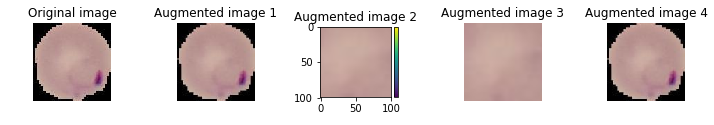

In [22]:
img_location = r'..\data\infected_8547.jpg'

plt.figure(figsize=(10,10))
plt.subplot(151)
plt.title('Original image')
imshow(imread(img_location))
plt.axis('off')

plt.subplot(152)
plt.title('Augmented image 1')
imshow(image_augmentation(img=img_location))
plt.axis('off')

plt.subplot(153)
plt.title('Augmented image 2')
imshow(image_augmentation(img=img_location))
plt.axis('off')

plt.subplot(154)
plt.title('Augmented image 3')
imshow(image_augmentation(img=img_location))
plt.axis('off')

plt.subplot(155)
plt.title('Augmented image 4')
imshow(image_augmentation(img=img_location))
plt.axis('off')

plt.show()

# Sample call to the generator help function

Below shows batches being generated of a 1000 images of 3D shape (100,100,3) along with the probability of each observations class label.

In [23]:
train_gen = training_generator(training_data=data_train.iloc[0:5500,:],batch_size=1000)
for x,y in train_gen:
    print(x.shape,y.shape)

(1000, 100, 100, 3) (1000, 2)
(1000, 100, 100, 3) (1000, 2)
(1000, 100, 100, 3) (1000, 2)
(1000, 100, 100, 3) (1000, 2)
(1000, 100, 100, 3) (1000, 2)
(1000, 100, 100, 3) (1000, 2)
(64, 100, 100, 3) (64, 2)


In [24]:
val_gen = cv_generator(cv_data=data_cv.iloc[0:5500,:],batch_size=1000)
for x,y in val_gen:
    print(x.shape,y.shape)

(1000, 100, 100, 3) (1000, 2)
(1000, 100, 100, 3) (1000, 2)
(1000, 100, 100, 3) (1000, 2)
(1000, 100, 100, 3) (1000, 2)
(1000, 100, 100, 3) (1000, 2)
(500, 100, 100, 3) (500, 2)


# Pixel value distributions

Below shows the distribution of the red,green and blue pixel value ranges. The red and blue distributions for higher pixel values seems very promising for creating a possible class seperation and will become a key feature during extraction of information.

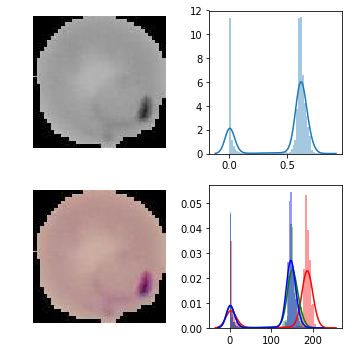

In [25]:
img_gray = imread(fname=img_location,as_gray=True)
img_rgb = imread(fname=img_location,as_gray=False)

hist = np.ravel(img_gray)
R = np.ravel(img_rgb[:,:,0])
G = np.ravel(img_rgb[:,:,1])
B = np.ravel(img_rgb[:,:,2])

plt.figure(figsize=(5,5))

plt.subplot(221)
plt.axis('off')
imshow(img_gray)

plt.subplot(222)
sns.distplot(hist)

plt.subplot(223)
plt.axis('off')
imshow(img_rgb)

plt.subplot(224)
sns.distplot(R,color='red')
sns.distplot(G,color='green')
sns.distplot(B,color='blue')

plt.tight_layout()
plt.show()

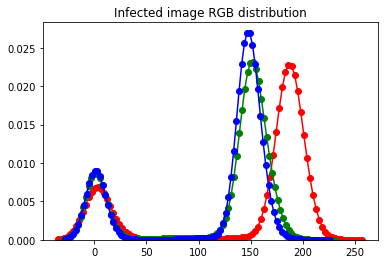

In [26]:
sns.kdeplot(R,marker='o',color='red')
sns.kdeplot(G,marker='o',color='green')
sns.kdeplot(B,marker='o',color='blue')
plt.title('Infected image RGB distribution')
plt.show()

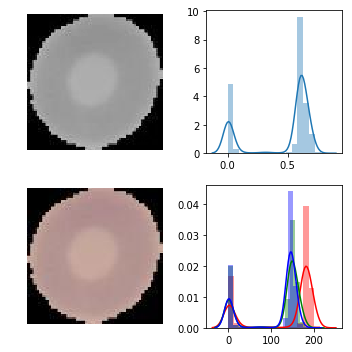

In [27]:
img_location = r'..\data\uninfected_25317.jpg'
img_gray = imread(fname=img_location,as_gray=True)
img_rgb = imread(fname=img_location,as_gray=False)

hist = np.ravel(img_gray)
R = np.ravel(img_rgb[:,:,0])
G = np.ravel(img_rgb[:,:,1])
B = np.ravel(img_rgb[:,:,2])

plt.figure(figsize=(5,5))

plt.subplot(221)
plt.axis('off')
imshow(img_gray)

plt.subplot(222)
sns.distplot(hist)

plt.subplot(223)
plt.axis('off')
imshow(img_rgb)

plt.subplot(224)
sns.distplot(R,color='red')
sns.distplot(G,color='green')
sns.distplot(B,color='blue')

plt.tight_layout()
plt.show()

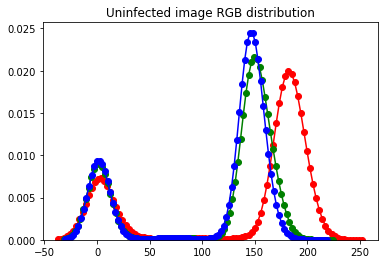

In [28]:
sns.kdeplot(R,marker='o',color='red')
sns.kdeplot(G,marker='o',color='green')
sns.kdeplot(B,marker='o',color='blue')
plt.title('Uninfected image RGB distribution')
plt.show()

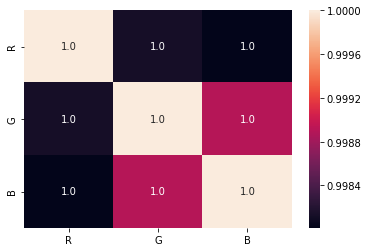

In [29]:
sns.heatmap(data=pd.DataFrame((np.array([R,G,B])),index=['R','G','B']).transpose().corr(),annot=True,fmt='.2')
plt.show()

## Segmentation

In [30]:
segmentation = rgb_mask_image(image=img_gray)

## Sobel edges

In [31]:
sobel_edges = sobel(img_gray)

## Thresholding

(<Figure size 576x360 with 8 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002228CD6D5F8>,
       dtype=object))

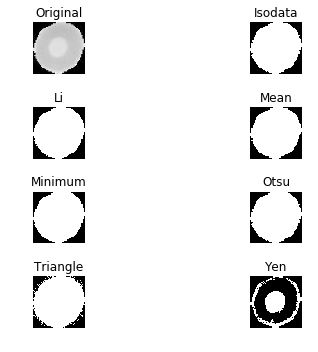

In [32]:
thresholding.try_all_threshold(image=img_gray,verbose=0)

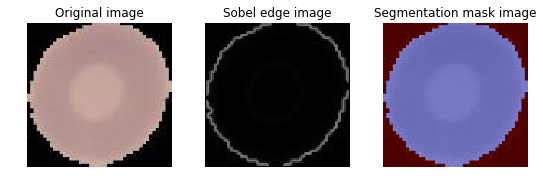

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(141)
plt.axis('off')
plt.title('Original image')
imshow(img_rgb)
plt.subplot(142)
plt.axis('off')
plt.title('Sobel edge image')
imshow(sobel_edges)
plt.subplot(143)
plt.axis('off')
plt.title('Segmentation mask image')
imshow(segmentation)
plt.show()

In [34]:
del data

# Data preprocessing

Only balance the class labels on the training data

In [35]:
label_to_upsample = np.argmin([data_train[data_train['image_label'].isin([0])].shape[0],
                               data_train[data_train['image_label'].isin([1])].shape[0]])

how_many_samples = np.max([data_train[data_train['image_label'].isin([0])].shape[0],
                           data_train[data_train['image_label'].isin([1])].shape[0]]) - \
                   np.min([data_train[data_train['image_label'].isin([0])].shape[0],
                           data_train[data_train['image_label'].isin([1])].shape[0]])

data_train = pd.concat(objs=[data_train,data_train[data_train['image_label'] == label_to_upsample].\
                             sample(n=how_many_samples)],axis=0)
data_train.reset_index(inplace=True,drop=True) 


X_train = data_train['image_location'].apply(lambda x: np.ravel(resize(image=imread(fname=x,as_gray=False),\
                                                                       output_shape=(25,25,3)))).values
A = pd.DataFrame(X_train)
X_train = pd.DataFrame(A.iloc[0:50000,0].values.tolist(), index= A.iloc[0:50000,0].index).values
Y_train = data_train['image_label'].values

In [36]:
X_cv = data_cv['image_location'].apply(lambda x: np.ravel(resize(image=imread(fname=x,as_gray=False),\
                                                                 output_shape=(25,25,3)))).values
A = pd.DataFrame(X_cv)
X_cv = pd.DataFrame(A[0].values.tolist(), index= A.index).values
Y_cv = data_cv['image_label'].values

In [37]:
X_test = data_test['image_location'].apply(lambda x: np.ravel(resize(image=imread(fname=x,as_gray=False),\
                                                                     output_shape=(25,25,3)))).values
A = pd.DataFrame(X_test)
X_test = pd.DataFrame(A[0].values.tolist(), index= A.index).values
Y_test = data_test['image_label'].values

Pixel values range between 0 and 255 hence we have to normalize the data

In [38]:
X_train_scaled = X_train/255
X_cv_scaled = X_cv/255
X_test_scaled = X_test/255

# Baseline Model

In [39]:
# generate random values:
random_values = np.random.rand(np.hstack((Y_train,Y_cv,Y_test)).shape[0],2)

# normalize the values (for prob to sum to 1):
totals = np.sum(random_values,axis=1)

# prob predictions:
prob_predictions = np.transpose(np.array([[i[0] for i in random_values]/totals,[i[1] for i in random_values]/totals]))

#predictions:
predictions = np.argmax(prob_predictions,axis=1)

In [40]:
auc = roc_auc_score(y_true=np.hstack((Y_train,Y_cv,Y_test)),y_score=[i[1] for i in prob_predictions])
print('Accuracy: {}'.format(round(accuracy_score(y_true=np.hstack((Y_train,Y_cv,Y_test)),y_pred=predictions)*100,2)))
print('Precision: {}'.format(round(precision_score(y_true=np.hstack((Y_train,Y_cv,Y_test)),y_pred=predictions)*100,2)))
print('Recall: {}'.format(round(recall_score(y_true=np.hstack((Y_train,Y_cv,Y_test)),y_pred=predictions)*100,2)))  
print('AUC: {}'.format(round(auc*100,2)))   

Accuracy: 50.03
Precision: 51.83
Recall: 50.03
AUC: 49.99


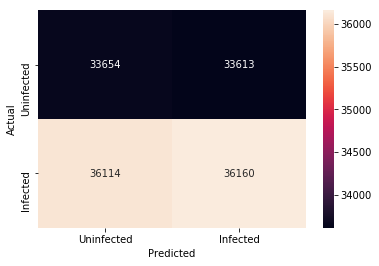

In [41]:
sns.heatmap(confusion_matrix(y_true=np.hstack((Y_train,Y_cv,Y_test)),y_pred=predictions),annot=True,fmt='2',\
            xticklabels=['Uninfected','Infected'],yticklabels=['Uninfected','Infected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

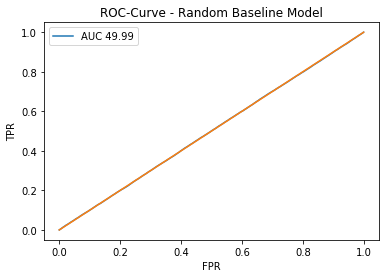

In [42]:
fpr,tpr,thresholds = roc_curve(y_true=np.hstack((Y_train,Y_cv,Y_test)),y_score=[i[1] for i in prob_predictions])
plt.plot(fpr,tpr,label='AUC {}'.format(round(auc*100,2)))
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-Curve - Random Baseline Model')
plt.legend()
plt.show()

As seen in the above image the random model is just the straight line on the ROC curve. We need to develop models that can outperform this random base line model. This basic model basically indicates that the best we'll do is get about 50% of the diagnosis right.

# Gaussian Naive Bayes Model

Don't need to use the scaled data for this model as this is not a distance based model

In [43]:
NB_model = GaussianNB()
NB_model.fit(X_train,Y_train[0:50000])
Y_cv_pred = NB_model.predict(X_cv)

In [44]:
NB_model.classes_

array([0, 1], dtype=int64)

In [45]:
print('Performance on CV data')
auc = roc_auc_score(y_true=Y_cv,y_score=[i[1] for i in NB_model.predict_proba(X_cv)])
print('Accuracy: {}'.format(round(accuracy_score(y_true=Y_cv,y_pred=Y_cv_pred)*100,2)))
print('Precision: {}'.format(round(precision_score(y_true=Y_cv,y_pred=Y_cv_pred)*100,2)))
print('Recall: {}'.format(round(recall_score(y_true=Y_cv,y_pred=Y_cv_pred)*100,2)))  
print('AUC: {}'.format(round(auc*100,2)))

Performance on CV data
Accuracy: 61.3
Precision: 71.28
Recall: 50.69
AUC: 67.33


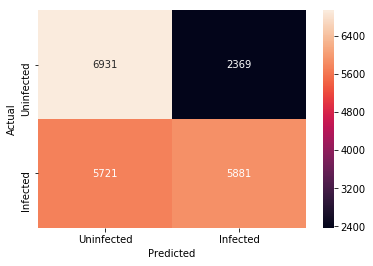

In [46]:
sns.heatmap(confusion_matrix(y_true=Y_cv,y_pred=Y_cv_pred),annot=True,fmt='2',xticklabels=['Uninfected','Infected'],\
            yticklabels=['Uninfected','Infected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

With the Naive Bayes model we achieve a precision of about 70%, which means that in 30% of the cases the model predictions will create false positive alarms that will invoke subsequent procedures to follow for these patients. This is not that bad. However the recall of the model is about 50% which means that in 50% of the cases the model predictions will create false negatives which will cause those 50% of patients to be turned home (where in fact they are infected with Malaria), this is bad as these patients will not receive the right treatment. For this medical application we will need a model that can improve the recall score.

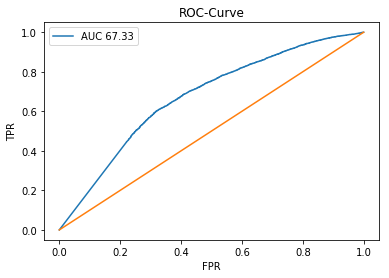

In [47]:
fpr,tpr,thresholds = roc_curve(y_true=Y_cv,y_score=[i[1] for i in NB_model.predict_proba(X_cv)])
plt.plot(fpr,tpr,label='AUC {}'.format(round(auc*100,2)))
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-Curve')
plt.legend()
plt.show()

The recall curve above shows that the model is still performing better than an average model where we would just randomly guess 50% of the time that a patient does not have Malaria.

## Sample prediction on test observations using Naive Bayes model

Predicted label: 0
Actual label: 0


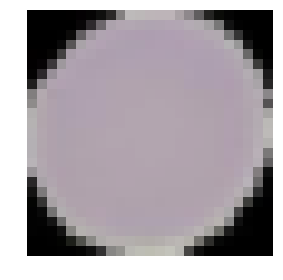

Predicted label: 1
Actual label: 0


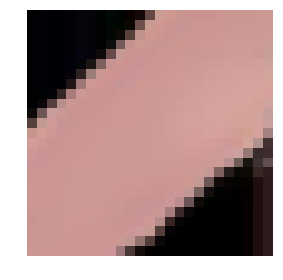

Predicted label: 1
Actual label: 0


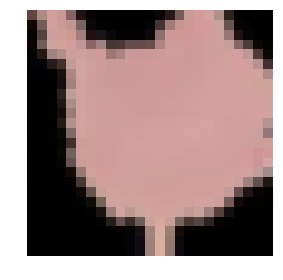

Predicted label: 1
Actual label: 1


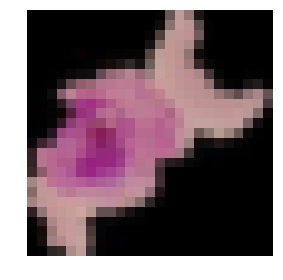

Predicted label: 0
Actual label: 1


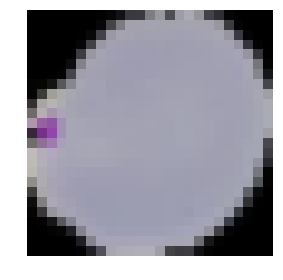

In [48]:
counter = 0
plt.figure()
for image,label in list(zip(X_test,Y_test)):
    print('Predicted label: {}'.format(NB_model.predict(X=[image])[0]))
    print('Actual label: {}'.format(label))
    imshow(np.reshape(a=image,newshape=(25,25,3)))
    plt.axis('off')
    plt.show()
    counter += 1
    if counter == 5:
        break  

# Logistic Regression Model

In [49]:
LR_model = LogisticRegression(penalty='l1',C=1000,n_jobs=-1)
LR_model.fit(X_train_scaled,Y_train[0:50000])
Y_cv_pred = LR_model.predict(X_cv_scaled)

In [50]:
LR_model.classes_

array([0, 1], dtype=int64)

In [52]:
print('Performance on CV data')
auc = roc_auc_score(y_true=Y_cv,y_score=[i[1] for i in LR_model.predict_proba(X_cv_scaled)])
print('Accuracy: {}'.format(round(accuracy_score(y_true=Y_cv,y_pred=Y_cv_pred)*100,2)))
print('Precision: {}'.format(round(precision_score(y_true=Y_cv,y_pred=Y_cv_pred)*100,2)))
print('Recall: {}'.format(round(recall_score(y_true=Y_cv,y_pred=Y_cv_pred)*100,2)))  
print('AUC: {}'.format(round(auc*100,2)))

Performance on CV data
Accuracy: 71.52
Precision: 74.07
Recall: 74.94
AUC: 78.09


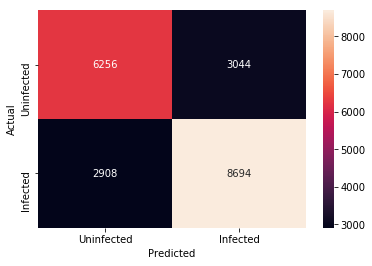

In [53]:
sns.heatmap(confusion_matrix(y_true=Y_cv,y_pred=Y_cv_pred),annot=True,fmt='2',xticklabels=['Uninfected','Infected'],\
            yticklabels=['Uninfected','Infected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

With the Logistic Regression model we achieve a precision of about 74%, which means that in 26% of the cases the model predictions will create false positive alarms that will invoke subsequent procedures to follow for these patients. This is not that bad. However the recall of the model is about 74% which means that in 26% of the cases the model predictions will create false negatives which will cause those 26% of patients to be turned home (where in fact they are infected with Malaria), this is bad as these patients will not receive the right treatment. For this medical application we will need a model that can improve the recall score even further.

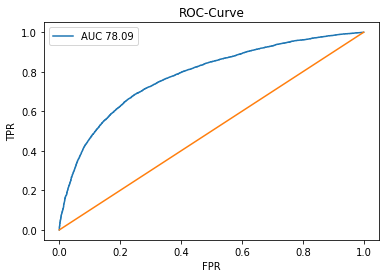

In [54]:
fpr,tpr,thresholds = roc_curve(y_true=Y_cv,y_score=[i[1] for i in LR_model.predict_proba(X_cv_scaled)])
plt.plot(fpr,tpr,label='AUC {}'.format(round(auc*100,2)))
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-Curve')
plt.legend()
plt.show()

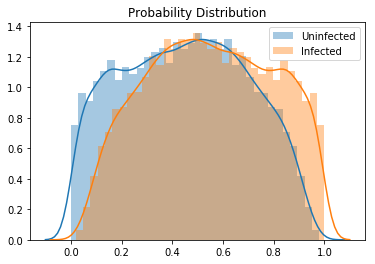

In [55]:
sns.distplot([i[0] for i in LR_model.predict_proba(X=X_cv_scaled)],label='Uninfected')
sns.distplot([i[1] for i in LR_model.predict_proba(X=X_cv_scaled)],label='Infected')
plt.title('Probability Distribution')
plt.legend()
plt.show()

In [56]:
precision,recall,thresholds = precision_recall_curve(y_true=Y_cv,\
                                                     probas_pred=[i[1] for i in LR_model.predict_proba(X=X_cv_scaled)])

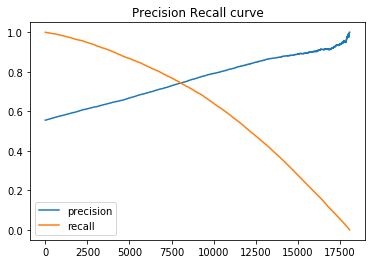

In [57]:
plt.plot(precision,label='precision')
plt.plot(recall,label='recall')
plt.title('Precision Recall curve')
plt.legend()
plt.show()

## Sample prediction on test observations using Logistic Regression model

Predicted label: 0
Actual label: 0


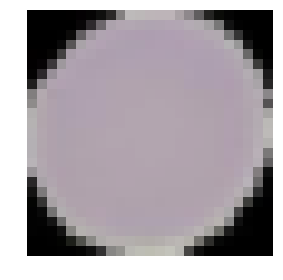

Predicted label: 0
Actual label: 0


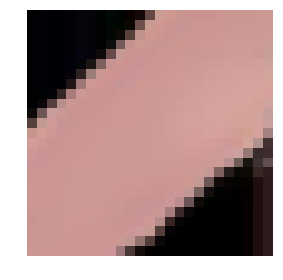

Predicted label: 0
Actual label: 0


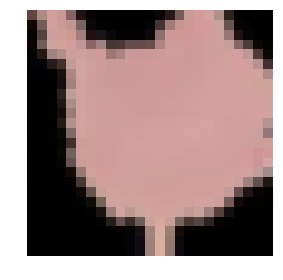

Predicted label: 0
Actual label: 1


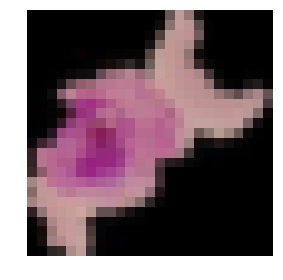

Predicted label: 0
Actual label: 1


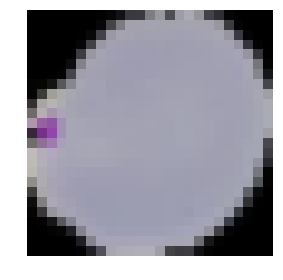

In [59]:
counter = 0
plt.figure()
for image,label in list(zip(X_test,Y_test)):
    print('Predicted label: {}'.format(LR_model.predict(X=[image])[0]))
    print('Actual label: {}'.format(label))
    imshow(np.reshape(a=image,newshape=(25,25,3)))
    plt.axis('off')
    plt.show()
    counter += 1
    if counter == 5:
        break       

# Applying segmentation transformation and then applying Bernoulli NB

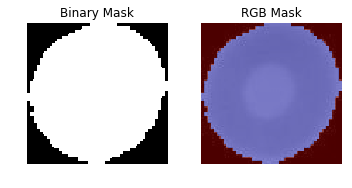

In [60]:
# using the helper masking functions we can do a transformation on the image (as below example shows)
plt.figure(figsize=(5,5))
plt.subplot(121)
plt.title('Binary Mask')
imshow(binary_mask_image(image=imread(fname=img_location,as_gray=True)))
plt.axis('off')

plt.subplot(122)
plt.title('RGB Mask')
imshow(rgb_mask_image(image=imread(fname=img_location,as_gray=True)))
plt.axis('off')
plt.show()

In [62]:
label_to_upsample = np.argmin([data_train[data_train['image_label'].isin([0])].shape[0],
                               data_train[data_train['image_label'].isin([1])].shape[0]])

how_many_samples = np.max([data_train[data_train['image_label'].isin([0])].shape[0],
                           data_train[data_train['image_label'].isin([1])].shape[0]]) - \
                   np.min([data_train[data_train['image_label'].isin([0])].shape[0],
                           data_train[data_train['image_label'].isin([1])].shape[0]])

data_train = pd.concat(objs=[data_train,data_train[data_train['image_label'] == label_to_upsample].\
                             sample(n=how_many_samples)],axis=0)
data_train.reset_index(inplace=True,drop=True) 


X_train_mask = data_train['image_location'].apply(lambda x: np.ravel(binary_mask_image(\
                                                  resize(image=imread(fname=x,as_gray=True),output_shape=(25,25))))).values
A = pd.DataFrame(X_train_mask)
X_train_mask = pd.DataFrame(A[0].values.tolist(), index= A.index).values
Y_train = data_train['image_label'].values

In [63]:
X_cv_mask = data_cv['image_location'].apply(lambda x: np.ravel(binary_mask_image(\
                                            resize(image=imread(fname=x,as_gray=True),output_shape=(25,25))))).values
A = pd.DataFrame(X_cv_mask)
X_cv_mask = pd.DataFrame(A[0].values.tolist(), index= A.index).values
Y_cv = data_cv['image_label'].values

In [64]:
X_test_mask = data_test['image_location'].apply(lambda x: np.ravel(binary_mask_image(
                                                resize(image=imread(fname=x,as_gray=True),output_shape=(25,25))))).values
A = pd.DataFrame(X_test_mask)
X_test_mask = pd.DataFrame(A[0].values.tolist(), index= A.index).values
Y_test = data_test['image_label'].values

In [65]:
for alpha in [0.0001,0.001,0.01,0.1,1,10,100,1000]:
    bernoulli_NB = BernoulliNB(alpha=alpha)
    bernoulli_NB.fit(X_train_mask,Y_train)
    y_pred = bernoulli_NB.predict(X_cv_mask)
    print(round(recall_score(y_true=Y_cv,y_pred=y_pred)*100,2))

38.09
38.09
38.09
38.09
38.09
38.01
37.48
33.93


In [66]:
bernoulli_NB_best = BernoulliNB(alpha=0.01)
bernoulli_NB_best.fit(X_train_mask,Y_train)
Y_cv_pred = bernoulli_NB_best.predict(X_cv_mask)

In [67]:
print('Performance on CV data')
auc = roc_auc_score(y_true=Y_cv,y_score=[i[1] for i in bernoulli_NB_best.predict_proba(X_cv_mask)])
print('Accuracy: {}'.format(round(accuracy_score(y_true=Y_cv,y_pred=Y_cv_pred)*100,2)))
print('Precision: {}'.format(round(precision_score(y_true=Y_cv,y_pred=Y_cv_pred)*100,2)))
print('Recall: {}'.format(round(recall_score(y_true=Y_cv,y_pred=Y_cv_pred)*100,2)))  
print('AUC: {}'.format(round(auc*100,2)))

Performance on CV data
Accuracy: 52.33
Precision: 61.38
Recall: 38.09
AUC: 62.75


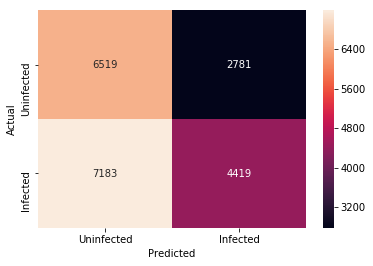

In [68]:
sns.heatmap(confusion_matrix(y_true=Y_cv,y_pred=Y_cv_pred),annot=True,fmt='2',xticklabels=['Uninfected','Infected'],\
            yticklabels=['Uninfected','Infected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

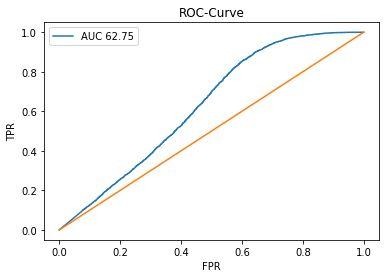

In [69]:
fpr,tpr,thresholds = roc_curve(y_true=Y_cv,y_score=[i[1] for i in bernoulli_NB_best.predict_proba(X_cv_mask)])
plt.plot(fpr,tpr,label='AUC {}'.format(round(auc*100,2)))
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-Curve')
plt.legend()
plt.show()

Predicted label: 0
Actual label: 0


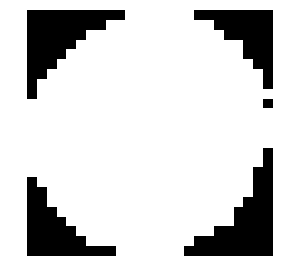

Predicted label: 1
Actual label: 0


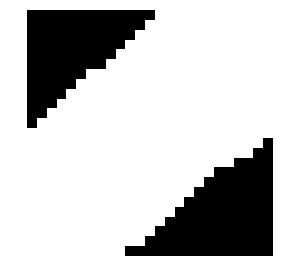

Predicted label: 1
Actual label: 0


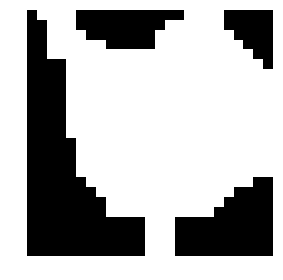

Predicted label: 1
Actual label: 1


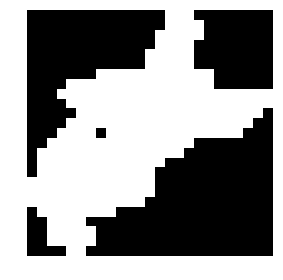

Predicted label: 0
Actual label: 1


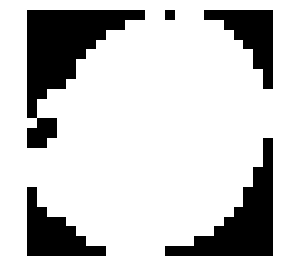

In [71]:
counter = 0
plt.figure()
for image,label in list(zip(X_test_mask,Y_test)):
    print('Predicted label: {}'.format(bernoulli_NB_best.predict(X=[image])[0]))
    print('Actual label: {}'.format(label))
    imshow(np.reshape(a=image,newshape=(25,25)))
    plt.axis('off')
    plt.show()
    counter += 1
    if counter == 5:
        break 

# Convolutional Neural Network

In [4]:
CNN_model = Sequential()

################### LAYER 1 ###################
CNN_model.add(Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same',data_format="channels_last",
                     activation='relu',kernel_initializer='glorot_uniform',input_shape=(100,100,3)))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.1))

################### LAYER 2 ###################
CNN_model.add(Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same',
                     activation='relu',kernel_initializer='glorot_uniform'))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.1))

################### LAYER 3 ###################
CNN_model.add(Conv2D(filters=64,kernel_size=(5,5),strides=(1,1),padding='same',
                     activation='relu',kernel_initializer='glorot_uniform'))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.1))

################### LAYER 4 ###################
CNN_model.add(Flatten())
CNN_model.add(Dense(units=10,activation='relu',kernel_initializer='glorot_uniform'))
CNN_model.add(BatchNormalization())
CNN_model.add(Dropout(0.1))

# OUTPUT LAYER
CNN_model.add(Dense(units=2, activation='softmax'));

In [32]:
CNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 64)      4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 25, 64)       

In [5]:
CNN_model.compile(optimizer=adam(lr=0.001),loss=binary_crossentropy,metrics=['accuracy']);

In [34]:
# callbacks:
model_checkpoint = ModelCheckpoint(filepath='..\\modelcheckpoints\\CNN_model_weights.h5',monitor='val_loss',save_best_only=True)
tensorboard = TensorBoard(log_dir='..\\tensorboardlog\\CNN_model',write_graph=True,write_grads=True,write_images=True,update_freq=1)

This saves the best model parameters to a log file only if an improvement is found based on the current best. After the images passed through the network the best model is loaded and it repeats the process passing the images through again....and again. The 3 times look at an images was chosen with no sciencific reasoning. However making it larger would not have improved anything as the solution pretty much already converged to the optimal after the first loop. The last two loops got to only about 2% improvement.

In [6]:
# steps_per_epoch is how many times a call will be made to the train generator to yield a batch of size: batch_size for every epoch
# validation_steps is how many times a call will be made to the validation generator to yield a batch of size: batch_size for every epoch
for model_run in range(3):
    
    train_gen = training_generator(training_data=data_train,batch_size=101)
    val_gen = cv_generator(cv_data=data_cv,batch_size=104)

    history = CNN_model.fit_generator(generator=train_gen,steps_per_epoch=41,epochs=20,verbose=1,
                                        callbacks=[model_checkpoint,tensorboard],
                                        validation_data=val_gen,
                                        validation_steps=10) #save best model during model check point
    CNN_model = load_model('..\\modelcheckpoints\\CNN_model_weights.h5') #load current best model and repeat.

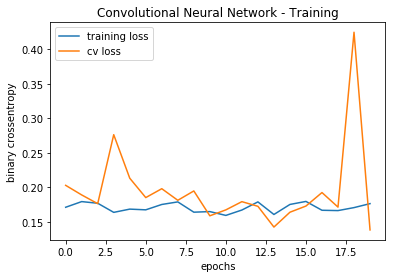

In [36]:
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='cv loss')
plt.xlabel('epochs')
plt.ylabel('binary crossentropy')
plt.title('Convolutional Neural Network - Training')
plt.legend()
plt.show()

This code yields batches of a 100 unseen images and uses the trained model (now stored on disk) to make predictions

In [37]:
test_gen = test_generator(test_data=data_test,batch_size=100)
y_true = list()
y_prd = list()
y_scores = list()
for X,Y in test_gen:
    y_act = np.argmax(Y,axis=1)
    y_true.append(y_act)
    y_pred_prob = CNN_model.predict(x=X)
    y_pred = np.argmax(y_pred_prob,axis=1)
    y_prd.append(y_pred)
    y_pred_prob_pos = [i[1] for i in y_pred_prob]
    y_scores.append(y_pred_prob_pos)

y_true = np.hstack(y_true)
y_pred = np.hstack(y_prd)
y_scores = np.hstack(y_scores)

In [38]:
auc = roc_auc_score(y_true=y_true,y_score=y_scores)
print('Accuracy: {}'.format(round(accuracy_score(y_true=y_true,y_pred=y_pred)*100,2)))
print('Precision: {}'.format(round(precision_score(y_true=y_true,y_pred=y_pred)*100,2)))
print('Recall: {}'.format(round(recall_score(y_true=y_true,y_pred=y_pred)*100,2)))
print('AUC: {}'.format(round(auc*100,2)))

Accuracy: 93.99
Precision: 97.53
Recall: 91.4
AUC: 98.68


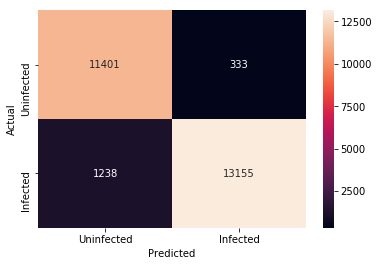

In [39]:
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,fmt='2',xticklabels=['Uninfected','Infected'],\
            yticklabels=['Uninfected','Infected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

With the Convolution Neural we achieve a precision of about 97%, which means that in 3% of the cases the model predictions will create false positive alarms that will invoke subsequent procedures to follow for these patients. This is not bad at all. However the recall of the model is about 91% which means that in 9% of the cases the model predictions will create false negatives which will cause those 9% of patients to be turned home (where in fact they are infected with Malaria), this is not great as these patients will not receive the right treatment. For this medical application we will need a model that can improve the recall score even further.

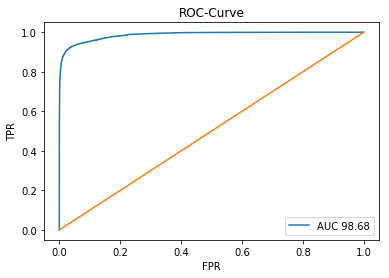

In [40]:
fpr,tpr,thresholds = roc_curve(y_true=y_true,y_score=y_scores)
plt.plot(fpr,tpr,label='AUC {}'.format(round(auc*100,2)))
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-Curve')
plt.legend()
plt.show()

This function will randomly sample 30 images make a prediction, compare to actual and repeat this 100 times. During this process the function will keep track of the accuracy scores. It then samples a 100 randomly chosen accuracy values with replacement computes the average accuracy and stores this in a sampling distribution array 100k times. The standard deviation and mean of the sampling distribution is computed to understand how the model would perform in the long run.

In [41]:
def test_model_inference(model):
    accuracy_scores = list()
    sampling_dist = list()
    for i in range(100):
        correct_count = 0
        for row in data.sample(n=30,replace=True).loc[:,['image_location','image_label']].iterrows():
            img = imread(fname=row[1]['image_location'],as_gray=False)
            img = resize(image=img,output_shape=(100,100,3))
            y_pred = np.argmax(model.predict(x=np.array([img])),axis=1)
            if y_pred[0] == row[1]['image_label']:
                correct_count += 1
        round_accuracy = round(correct_count/30*100,2)
        accuracy_scores.append(round_accuracy)

    for i in range(100000):
        sampling_dist.append(np.mean(np.random.choice(a=accuracy_scores,size=100,replace=True)))

    sample_mean = np.mean(sampling_dist)
    sample_std = np.std(sampling_dist)
    
    return sampling_dist,sample_mean,sample_std

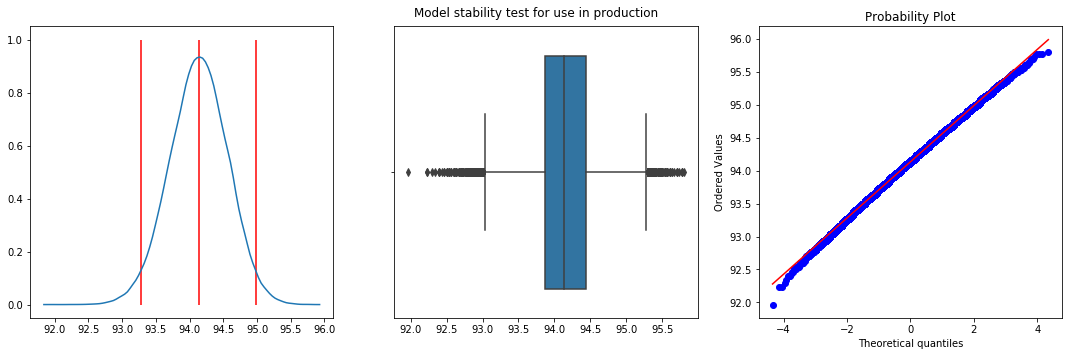

In [55]:
sampling_dist,sample_mean,sample_std = test_model_inference(model=CNN_model)

fig = plt.figure(figsize=(15,5))
fig.suptitle('Model stability test for use in production')
plt.subplot('131')
sns.kdeplot(sampling_dist)
plt.vlines(x=sample_mean,ymin=0,ymax=1,color='red')
plt.vlines(x=-2*sample_std + sample_mean,ymin=0,ymax=1,color='red')
plt.vlines(x=2*sample_std + sample_mean,ymin=0,ymax=1,color='red')

plt.subplot('132')
sns.boxplot(sampling_dist)

plt.subplot('133')
stats.probplot(sampling_dist,dist='norm',plot=pylab)

plt.tight_layout()
plt.show()

The above bootstrap simulation shows that the model will consistantly have about 94% of the predictions correct. The outliers indicate that in rare times the models worst performance is just under 93% of the predictions being correctly predicted. With 95% confidence interval the predictions will fluctuate between 93% and 96% which is only a 3% deviation at times. I expected these results since there were very little difference between train and validation loss and metrics (the solution converged well)

# Transfer learning VGG19 model architecture

Transfer learning is a great concept where one does not need to have large quantities of data nor the hardware to compute and optimize very deep neural networks. Thanks to the likes of Google and other contributers there are already pre-trained architectures of deep networks that has been run on millions of data points. One such model is called VGG19 the child to VGG16. These models has been trained on a very large set called imagenet. The idea is that one can use this structure and only add on the tail layers that you train for your domain specific problem (in this case malaria classifation).

In [7]:
modelVGG19 = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=(100,100,3));

In [8]:
VGG19_model = Sequential()

for layer in modelVGG19.layers:
    VGG19_model.add(layer) #reuse the layers of the VGG19 model

# dont retrain the pretrained model:    
for layer in VGG19_model.layers:
    layer.trainable = False #these layer weights have already been trained on imagenet data.

# add the tail end of your layers for your domain to solve:    
VGG19_model.add(Flatten())
VGG19_model.add(Dense(units=10,activation='relu',kernel_initializer='glorot_uniform'))
VGG19_model.add(BatchNormalization())
VGG19_model.add(Dropout(0.1))

# OUTPUT LAYER
VGG19_model.add(Dense(units=2, activation='softmax'));

In [74]:
VGG19_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 25, 25, 256)      

In [9]:
VGG19_model.compile(optimizer=adam(lr=0.001),loss=binary_crossentropy,metrics=['accuracy']);

In [76]:
# callbacks:
model_checkpoint = ModelCheckpoint(filepath='..\\modelcheckpoints\\VGG19_model_weights.h5',monitor='val_loss',save_best_only=True)
tensorboard = TensorBoard(log_dir='..\\tensorboardlog\\VGG19_model',write_graph=True,write_grads=True,write_images=True,update_freq=1)

In [10]:
train_gen = training_generator(training_data=data_train,batch_size=101)
val_gen = cv_generator(cv_data=data_cv,batch_size=104)

history = VGG19_model.fit_generator(generator=train_gen,steps_per_epoch=41,epochs=20,verbose=1,
                                    callbacks=[model_checkpoint,tensorboard],
                                    validation_data=val_gen,
                                    validation_steps=10)

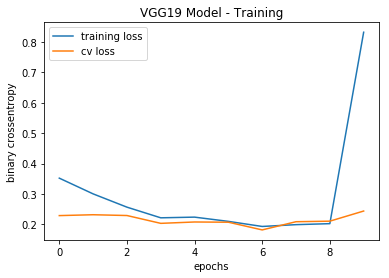

In [76]:
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='cv loss')
plt.xlabel('epochs')
plt.ylabel('binary crossentropy')
plt.title('VGG19 Model - Training')
plt.legend()
plt.show()

In [77]:
test_gen = test_generator(test_data=data_test,batch_size=100)
y_true = list()
y_prd = list()
y_scores = list()
for X,Y in test_gen:
    y_act = np.argmax(Y,axis=1)
    y_true.append(y_act)
    y_pred_prob = VGG19_model.predict(x=X)
    y_pred = np.argmax(y_pred_prob,axis=1)
    y_prd.append(y_pred)
    y_pred_prob_pos = [i[1] for i in y_pred_prob]
    y_scores.append(y_pred_prob_pos)

y_true = np.hstack(y_true)
y_pred = np.hstack(y_prd)
y_scores = np.hstack(y_scores)

In [78]:
auc = roc_auc_score(y_true=y_true,y_score=y_scores)
print('Accuracy: {}'.format(round(accuracy_score(y_true=y_true,y_pred=y_pred)*100,2)))
print('Precision: {}'.format(round(precision_score(y_true=y_true,y_pred=y_pred)*100,2)))
print('Recall: {}'.format(round(recall_score(y_true=y_true,y_pred=y_pred)*100,2)))
print('AUC: {}'.format(round(auc*100,2)))

Accuracy: 90.7
Precision: 89.48
Recall: 94.2
AUC: 96.19


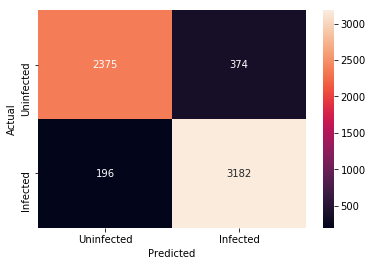

In [79]:
sns.heatmap(confusion_matrix(y_true=y_true,y_pred=y_pred),annot=True,fmt='2',xticklabels=['Uninfected','Infected'],\
            yticklabels=['Uninfected','Infected'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

With the Convolution Neural (VGG19) we achieve a precision of about 89%, which means that in 11% of the cases the model predictions will create false positive alarms that will invoke subsequent procedures to follow for these patients. This is not bad at all. However the recall of the model is about 94% which means that in 6% of the cases the model predictions will create false negatives which will cause those 6% of patients to be turned home (where in fact they are infected with Malaria), this is not great as these patients will not receive the right treatment. For this medical application we will need a model that can improve the recall score even further.

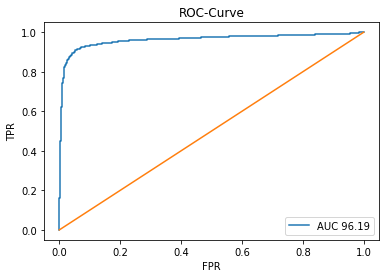

In [80]:
fpr,tpr,thresholds = roc_curve(y_true=y_true,y_score=y_scores)
plt.plot(fpr,tpr,label='AUC {}'.format(round(auc*100,2)))
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-Curve')
plt.legend()
plt.show()

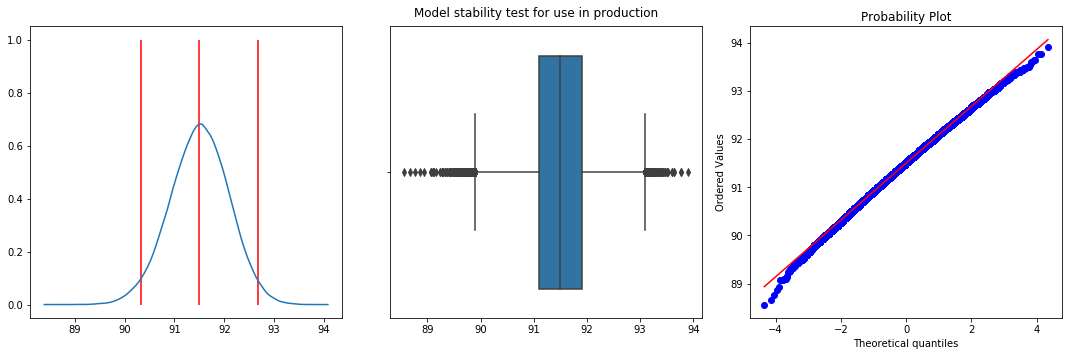

In [159]:
sampling_dist,sample_mean,sample_std = test_model_inference(model=VGG19_model)

fig = plt.figure(figsize=(15,5))
fig.suptitle('Model stability test for use in production')
plt.subplot('131')
sns.kdeplot(sampling_dist)
plt.vlines(x=sample_mean,ymin=0,ymax=1,color='red')
plt.vlines(x=-2*sample_std + sample_mean,ymin=0,ymax=1,color='red')
plt.vlines(x=2*sample_std + sample_mean,ymin=0,ymax=1,color='red')

plt.subplot('132')
sns.boxplot(sampling_dist)

plt.subplot('133')
stats.probplot(sampling_dist,dist='norm',plot=pylab)

plt.tight_layout()
plt.show()

The above bootstrap simulation shows that the model will consistantly have about 91% of the predictions correct. The outliers indicate that in rare times the models worst performance is just under 90% of the predictions being correctly predicted. With 95% confidence interval the predictions will fluctuate between 90% and 93% which is only a 3% deviation at times.

# Conclusion

Thank you for the time reading through my work. I'll leave it to the reader to see if you can get the recall score above 94%. If you do please share with me your findings as I believe there can always be room for improvement.